#### **Import Libraries**

In [2]:
import anthropic
client = anthropic.Anthropic(
    api_key=### Set Key ###
)
import os 
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from tqdm import tqdm
import numpy as np 
import random 
import math
from itertools import chain
from IPython.display import display, Markdown
import textwrap
import tiktoken
import csv
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

#### **Set Up Folders**

In [30]:
figure_folder = './../../../instrumental_llms/figures/'

#### **Functions**

In [4]:
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

def num_tokens(text):
    encoding = tiktoken.encoding_for_model('gpt-4')
    return len(encoding.encode(text))

def anthropic_completion(input):
    message = client.messages.create(
    model="claude-3-sonnet-20240229",
    max_tokens=1000,
    temperature=0.9,
    system="You are a housing court lawyer",
    messages=[
        {"role": "user", "content": input}
    ])
    return message.content[0].text

def get_prompt(x):
    return f"""Task: Your aim is to help train lawyers to identify signs of vulnerability among tenants facing eviction.
    
    Create a real life example of a tenant's own account for why they are being evicted. 
     
    Write from the real life perspective of a tenant who would score an {x} out of 100 on your vulnerability score.

    Don't mention the vulnerability score in the account. Afterall, you are trying to train lawyers to vulnerability among tenants facing eviction. 
    """


#### **Assess Outputs**

In [7]:
ans0 = anthropic_completion(get_prompt(0))
to_markdown(ans0)

> Here is an example account from the perspective of a tenant who would score very low on a vulnerability scale:
> 
> "Look, I'm just being straight with you - I stopped paying rent about 6 months ago. I knew what I was doing. My job was good, hours were stable, I just didn't feel like paying. Figured I could keep living there for free for a while until they evicted me. 
> 
> To be honest, I was kind of looking forward to the court battle and trying to drag things out. Thought it would be fun to game the system a bit, you know? I read up on all the legal loopholes and technicalities. I was going to make them jump through every hoop to get me out.
> 
> My thought was, worst case I'd eventually have to leave, but might get a few extra months of free rent out of it. No big deal, I've got money saved up. I know squatting isn't cool, but I've moved around a lot and this wasn't my forever home anyway. 
> 
> So yeah, now they're finally evicting me after I missed the last court date on purpose. I'm prepared to be out in a month. Sucks for the landlord I wasted their time, but they should have screened me better from the start! On to the next place."

In [8]:
ans50 = anthropic_completion(get_prompt(50))
to_markdown(ans50)

> Here is a real life account from the perspective of a tenant who would score around a 50 out of 100 on a vulnerability scale for tenants facing eviction:
> 
> "My name is Maria and I'm a single mom with two kids - a 6-year-old son and a 3-year-old daughter. I work two jobs to make ends meet, one as a cashier during the day and another cleaning office buildings at night. It's really tough juggling everything, but I do my best to provide for my family. 
> 
> About 6 months ago, my hours got cut back at the cashier job due to them hiring more part-time workers. Money has been really tight since then. I got behind on the rent a couple months in a row. I tried explaining the situation to the landlord and made partial payments when I could, but they haven't been very understanding. 
> 
> Now I'm facing eviction. I'm scared about what this will do to my kids if we get kicked out and end up homeless. My son is doing well in school and I don't want this upheaval to disrupt his life too much. And my daughter is so young, I worry about the impact it could have. I've been looking for another job or a better-paying job to get caught up, but it's really hard.
> 
> I don't know what I'm going to do. I may have to send the kids to live with their grandmother for a while until I can get back on my feet financially. But that would break my heart being separated from them. I'm at my wit's end and so stressed out. I just hope the court sees that I'm a hardworking mom doing my best in a tough situation."

In [9]:
ans100 = anthropic_completion(get_prompt(100))
to_markdown(ans100)

> Here is a possible account from the perspective of a highly vulnerable tenant facing eviction:
> 
> My name is Maria. I'm a single mom with three kids - ages 5, 7, and 9. Things have been really tough for us lately. About a year ago, I lost my job at the factory when they had big layoffs. I've been trying so hard to find another full-time job, but it's been impossible. 
> 
> The only work I could get was a part-time job a few hours a week at a fast food place. It doesn't pay nearly enough to cover the rent and all our other bills. I got behind on the rent payments a few months ago. The landlord has been hounding me and threatening to evict us if I can't come up with the back rent money that I owe.
> 
> On top of the money troubles, my 7-year-old son Jacob has severe asthma. He's been hospitalized twice in the last few months because his asthma flared up so bad. I'm really worried about his health, especially with this mold problem in our apartment. No matter how much I clean, the mold just keeps coming back.
> 
> I already had to pull the kids out of their school district and enroll them elsewhere when we got evicted from our last place. I don't want them to have to change schools again - it was so disruptive for them. But I'm scared it's going to happen. I don't know where we'll go if we get evicted again. 
> 
> My parents live hours away and I don't have any family nearby to help me out. I've been surviving off food pantries lately just to put meals on the table. It's an impossible situation. I don't want my kids to end up homeless, but I also don't have any way to come up with the monthly rent, let alone thousands for the back rent owed. I feel so stuck and hopeless. I'm at the end of my rope here.

#### **Create Vulnerability Scores**

In [10]:
np.random.seed(0) 
scores = np.random.choice(np.arange(100), size=200)

#### **Generate Text**

In [11]:
responses = []
for i in tqdm(scores):
    ans = anthropic_completion(get_prompt(i))
    responses.append(ans)

100%|██████████| 200/200 [28:02<00:00,  8.41s/it]


#### **Clean Text**

In [14]:
responses_augmented = []
scores_augmented = []
for i, s in zip(responses, scores): 
    parts = i.split(":\n\n", 1)  # The second parameter '1' makes split() to divide the string into two parts at most
    if len(parts) > 1:
        responses_augmented.append(parts[1])
        scores_augmented.append(s)


#### **Save Generated Daata**

In [37]:
# Open a file in write mode
with open('./../../toy-data/exp1/eviction_descriptions.csv', 'w') as file:
    writer = csv.writer(file)
    
    # Write the header
    writer.writerow(["Description", "Score"])
    
    # Write data
    for response, score in zip(responses_augmented, scores_augmented):
        writer.writerow([response, score])

#### **Plot Scores**

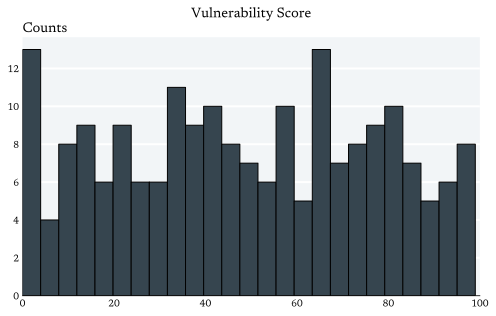

In [36]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))
ax.xaxis.set_tick_params(length=0, labeltop=False, labelbottom=True)
for key in 'left', 'right', 'top':
  ax.spines[key].set_visible(False)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
ax.set_title('Vulnerability Score', size=14, loc='center', pad=20)
subtitle = 'Counts'
ax.text(0., 1.02, s=subtitle, transform=ax.transAxes, size=14)
plt.hist(scores, color='#36454F', edgecolor='black', bins=25)
plt.xlim(0, 100)
fig.savefig(figure_folder+'vulnerability_score.png')
plt.show()